In [ ]:
#ДЗ 
# 1. Для изображения sar_3.jpg найти наиболее протяженный участок
# (выделить линии при помощи преобразования Хафа)
# 2. Для изображения sar_3.jpg провести исследование алгоритмов бинаризации, выделить участок дорожной полосы.

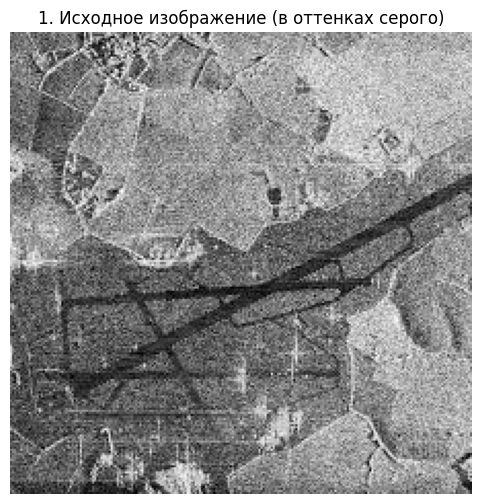

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, util, measure
from skimage.color import rgb2gray

image_path = 'sar_3.jpg'
image_color = cv2.imread(image_path)

if image_color is None:
    raise FileNotFoundError(f"Не удалось найти файл {image_path}")


image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
image_gray_f = util.img_as_float(image_gray)

plt.figure(figsize=(8, 6))
plt.imshow(image_gray, cmap='gray')
plt.title("1. Исходное изображение (в оттенках серого)")
plt.axis('off')
plt.show()

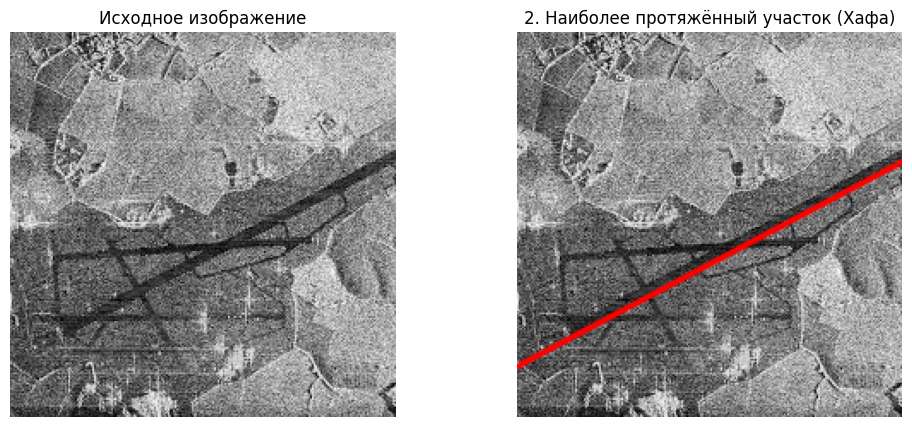

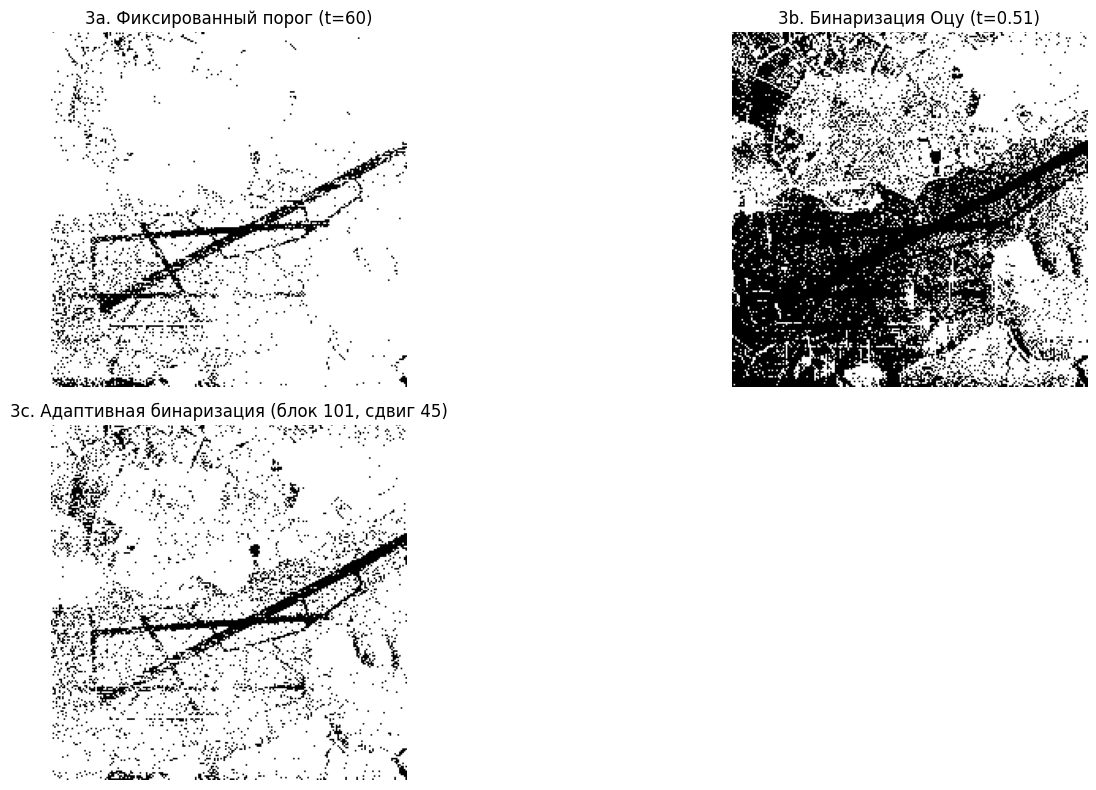

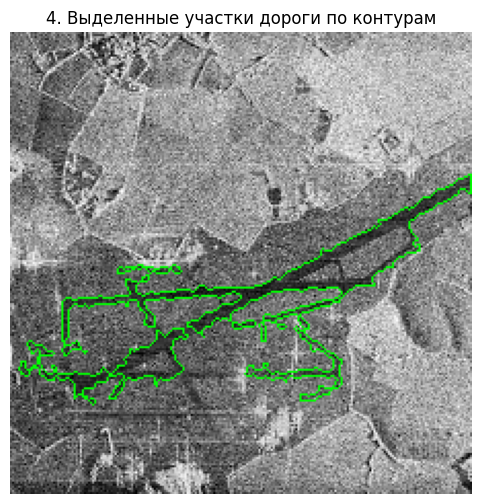

In [2]:
edges = cv2.Canny(image_gray, 100, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 135)

max_length = 0
longest_line = None

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        length = np.hypot(pt1[0] - pt2[0], pt1[1] - pt2[1])
        if length > max_length:
            max_length = length
            longest_line = (pt1, pt2)

image_with_line = image_color.copy()
if longest_line is not None:
    cv2.line(image_with_line, longest_line[0], longest_line[1], (0, 0, 255), 2, cv2.LINE_AA)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_line, cv2.COLOR_BGR2RGB))
plt.title("2. Наиболее протяжённый участок (Хафа)")
plt.axis('off')
plt.show()


_, binary_fixed = cv2.threshold(image_gray, 60, 255, cv2.THRESH_BINARY)


thresh_otsu = filters.threshold_otsu(image_gray_f)
binary_otsu = image_gray_f > thresh_otsu


adaptive_binary = cv2.adaptiveThreshold(
    image_gray, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,
    101, 45
)


plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.imshow(binary_fixed, cmap='gray')
plt.title("3a. Фиксированный порог (t=60)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(binary_otsu, cmap='gray')
plt.title(f"3b. Бинаризация Оцу (t={thresh_otsu:.2f})")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(adaptive_binary, cmap='gray')
plt.title("3c. Адаптивная бинаризация (блок 101, сдвиг 45)")
plt.axis('off')
plt.tight_layout()
plt.show()


blurred = cv2.GaussianBlur(adaptive_binary, (7, 7), 0)
thresh_inv = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)

contours, _ = cv2.findContours(thresh_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

lane_image = image_color.copy()
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 500:
        cv2.drawContours(lane_image, [contour], -1, (0, 255, 0), 1)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB))
plt.title("4. Выделенные участки дороги по контурам")
plt.axis('off')
plt.show()